In [1]:
# Regular EDA and plotting Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

# import xgboost
# import lightgbm


# We want our plots to appear in the notebook
#matplotlib inline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

#Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_roc_curve

In [3]:
df = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# Splitting our dataframe to run a proper model that will permit us to get the correct feature importances from our dataframe
# Data split into X and y
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

#Running and fitting the Extratressclassifier model
et=ExtraTreesClassifier()
et.fit(X,y)

# Running feature importance from our dataframe
et.feature_importances_

array([0.0936576 , 0.02405202, 0.07425576, 0.02956527, 0.1287706 ,
       0.02408373, 0.07000693, 0.12357926, 0.08771087, 0.02538445,
       0.02547527, 0.29345823])

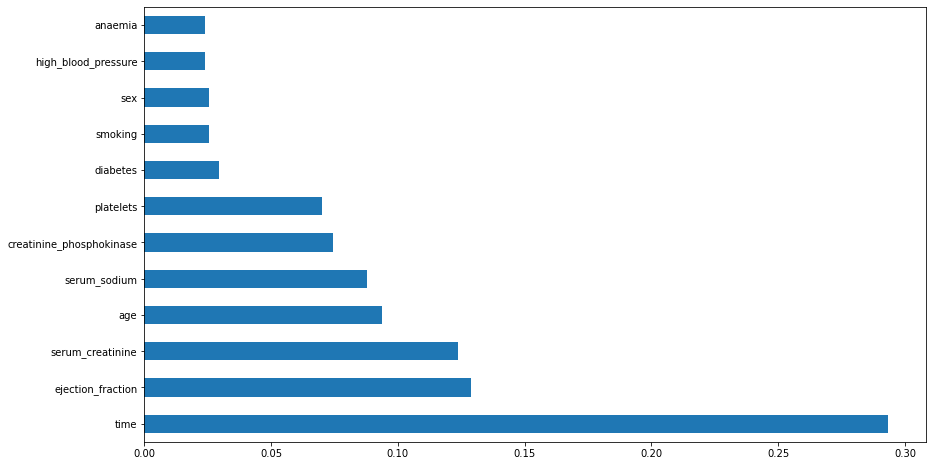

In [5]:
plt.figure(figsize=(14,8))
feat_importances = pd.Series(et.feature_importances_, index=X.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

## We shall select top 4 features from above graph and use it for our model building

In [56]:
#We shall select only 4 features
X = df[['time', 'ejection_fraction', 'serum_creatinine','age', 'serum_sodium', 'creatinine_phosphokinase', 'platelets']]
y = df['DEATH_EVENT']

In [57]:
# Splitting data into X and y for modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [58]:
# We will be Scaling the training data to learn the scaling parameters of our data.

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

## Feature Engineering..........

In [59]:
# PUtting models in a dictionary
models = {'KNN': KNeighborsClassifier(),
          'Logistic Regression': LogisticRegression(),
          'Random Forest': RandomForestClassifier(),
#           'Scaler': StandardScaler(),
          'SVC': SVC(),
          'DecisionTreeClassifier': DecisionTreeClassifier()}

# Creating functions to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different scikit=learn machine learning models
    x_train: training data
    x_test: testing data
    y_train: labels associated with training data
    y_test: labels associated with test data
    """
    # Randomseed for reproducible results
    np.random.seed(0)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        #fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores
        

In [60]:
# Fitting data into all models
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
model_scores

{'DecisionTreeClassifier': 0.7333333333333333,
 'KNN': 0.7333333333333333,
 'Logistic Regression': 0.8,
 'Random Forest': 0.8666666666666667,
 'SVC': 0.85}

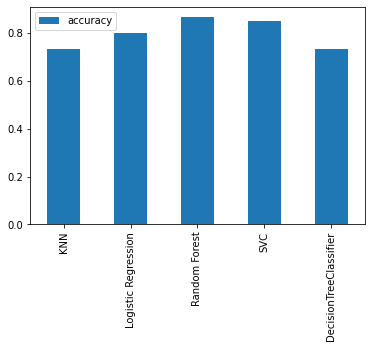

In [61]:
#Visualizing model scores
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

 ### Lets try to increase our Accuracy by checking out if we have major outliers then remove them to exploire further

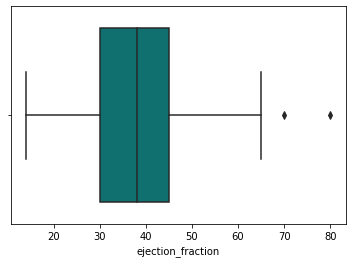

In [62]:
# Checking the ejection_fraction for outliers visually using boxplot
sns.boxplot(x = df.ejection_fraction, color = 'teal')
plt.show()

In [63]:
# Major ejection_fraction outliers to be removed
df[df['ejection_fraction']>=70]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
64,45.0,0,582,0,80,0,263358.03,1.18,137,0,0,63,0
217,54.0,1,427,0,70,1,151000.00,9.00,137,0,0,196,1


In [64]:
# Creating new Datafrome without ejection_fractoin outliers
# ejection_fraction outliers
df1=df[df['ejection_fraction']<70]

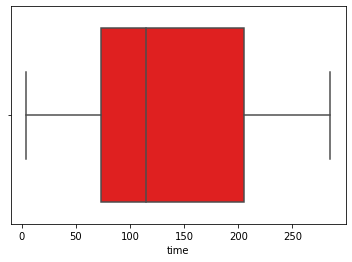

In [65]:
# Checking for possible outliers in Time
sns.boxplot(x=df1.time, color = 'red')
plt.show()
# No outliers in the Time column

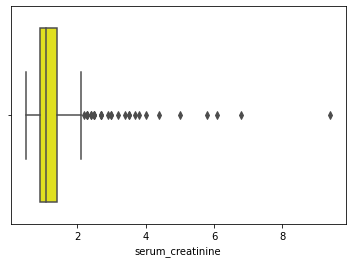

In [66]:
# Checking for outliers in serum_creatinine
sns.boxplot(x=df1.serum_creatinine, color = 'yellow')
plt.show()

In [67]:
## After Due research, I noted that Serum_creatinine can frequently have outliers like the one found in the image above

In [68]:
# I will reinstantiate our X and y splits with the new dataframe
X = df1[['time', 'ejection_fraction', 'serum_creatinine','age', 'serum_sodium', 'creatinine_phosphokinase', 'platelets']]
y = df1['DEATH_EVENT']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [70]:
scaler=StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [71]:
# We will Run our model again by calling the defined function
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
model_scores

{'DecisionTreeClassifier': 0.9166666666666666,
 'KNN': 0.8333333333333334,
 'Logistic Regression': 0.9,
 'Random Forest': 0.9333333333333333,
 'SVC': 0.8666666666666667}

## Now we notice a big improvement on our model after removing the outlier

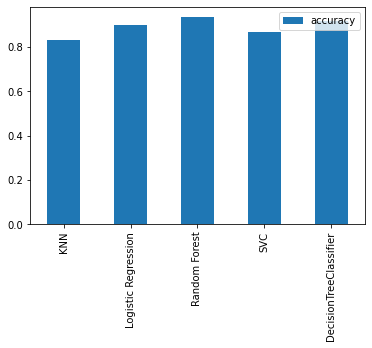

In [72]:
#Visualizing model scores
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

### Let's fine tume our individual models and see if we will generate better scores

In [73]:

knn_predict = KNeighborsClassifier()
logistic_predict = LogisticRegression()
random_predict = RandomForestClassifier()
svc_predict = SVC()
decision_predict = DecisionTreeClassifier()

knn_predict.fit(X_train, y_train)
logistic_predict.fit(X_train, y_train)
random_predict.fit(X_train, y_train)
svc_predict.fit(X_train, y_train)
decision_predict.fit(X_train, y_train)

knn_pred = knn_predict.predict(X_test)
logistic_pred = logistic_predict.predict(X_test)
random_pred = logistic_predict.predict(X_test)
svc_pred = svc_predict.predict(X_test)
decision_pred = decision_predict.predict(X_test)

In [74]:
# Lets start by checking some metrics on the models so far
# Confusion matrix
print('knn_pred: ', confusion_matrix(y_test,knn_pred)), print('logistic_pred; ', confusion_matrix(y_test, logistic_pred)), print('random_pred: ', confusion_matrix(y_test,random_pred)), print('svc_pred: ', confusion_matrix(y_test,svc_pred)), 
print('decision_pred: ', confusion_matrix(y_test,decision_pred))

knn_pred:  [[40  3]
 [ 7 10]]
logistic_pred;  [[40  3]
 [ 3 14]]
random_pred:  [[40  3]
 [ 3 14]]
svc_pred:  [[40  3]
 [ 5 12]]
decision_pred:  [[38  5]
 [ 1 16]]


In [75]:
# Lets start by checking some metrics on the models so far
# Classification Report
print('knn_pred: ', classification_report(y_test,knn_pred)), print('logistic_pred; ', classification_report(y_test, logistic_pred)), print('random_pred: ', classification_report(y_test,random_pred)), print('svc_pred: ', classification_report(y_test,svc_pred)), 
print('decision_pred: ', confusion_matrix(y_test,decision_pred))

knn_pred:                precision    recall  f1-score   support

           0       0.85      0.93      0.89        43
           1       0.77      0.59      0.67        17

    accuracy                           0.83        60
   macro avg       0.81      0.76      0.78        60
weighted avg       0.83      0.83      0.83        60

logistic_pred;                precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.82      0.82      0.82        17

    accuracy                           0.90        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.90      0.90      0.90        60

random_pred:                precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.82      0.82      0.82        17

    accuracy                           0.90        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.90      0.90

## Let us start fine tuning the KNeighborsClassifier

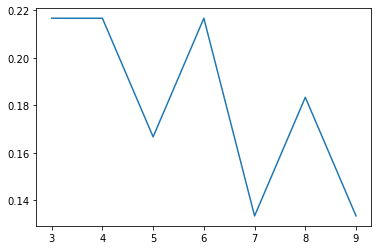

In [76]:
# Let us code and plot to find the k-neighbors digit with the lowest error possible
#Choosing K value
list1=[]
for k in range(3,10):
    classifier=KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    errors=1-accuracy_score(y_test,y_pred)
    list1.append(errors)
plt.plot(list(range(3,10)),list1)
plt.show()

## The plot above shows the k-neighbors figure with the lowest possible error ranges from 5 to 9

In [78]:
# We will tune KNeigbors with parameter 5 and hope for better results
classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train, y_train)

kpred=classifier.predict(X_test)
classifier.score(X_test, y_test), confusion_matrix(y_test, kpred)

(0.8666666666666667, array([[40,  3],
        [ 5, 12]]))

### The above result shows KNeighbors isn't improving

#### Fine Tuning Logistic Regression and RandomForest using GridSearchCV


In [79]:
# hyperparameters to be used for logisticRegression (RandomSearchCV and GridsearchCV)
log_reg_grid = {'C': np.logspace(-4,4,20),
                'solver': ['liblinear']}

# hyperparameters to be used for RandomForest (RandomSearchCV and GridsearchCV)
rf_grid = {'n_estimators': np.arange(10,1000,50),
           'max_depth': [None, 3,5,10],
           'min_samples_split': np.arange(2,20,2),
           'min_samples_leaf': np.arange(1,20,2)}

In [80]:
## We will let RandomizedSearchCV try 20 different combinations of hyperparameters
np.random.seed(0)

# Setting up random hyperparameter search for logisticregression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions = log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [81]:
# Pulling the best parameter from all different combinations (RandomSearchCV - LogisticRegression)
rs_log_reg.best_params_

{'C': 0.23357214690901212, 'solver': 'liblinear'}

In [82]:
# New LogisticRegression score after RandomSearchCV tuning
rs_log_reg.score(X_test, y_test)

0.9

In [83]:
# Comparing scores after tuning with former scores 
# New LogisticRegression score after RandomSearchCV tuning
print('current score after tuning LOgisticRegression: ', rs_log_reg.score(X_test, y_test)), model_scores

current score after tuning LOgisticRegression:  0.9


(None,
 {'DecisionTreeClassifier': 0.9166666666666666,
  'KNN': 0.8333333333333334,
  'Logistic Regression': 0.9,
  'Random Forest': 0.9333333333333333,
  'SVC': 0.8666666666666667})

### Logistic Regression score remains thesame. NO CHANGE SO FAR

### Now we fine tune RandomForestClassifier using RandomSEarchCV

In [88]:
# np.random.seed(0)
# setup random hyperparameter search for RandomForestClassifer
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                               param_distributions=rf_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True)

# fit random hyperparameter search model
rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [89]:
# Pulling the best parameter from all different combinations (RandomSearchCV - RandomForestClassifier)
rs_rf.best_params_

{'max_depth': 3,
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 760}

In [90]:
# Evaluate te randomized search random forest model
rs_rf.score(X_test, y_test)

0.9166666666666666

In [91]:
# Comparing scores after tuning with former scores 
# New LogisticRegression score after RandomSearchCV tuning
print('current score after tuning RandomForestClassifier: ', rs_rf.score(X_test, y_test)), model_scores

current score after tuning RandomForestClassifier:  0.9166666666666666


(None,
 {'DecisionTreeClassifier': 0.9166666666666666,
  'KNN': 0.8333333333333334,
  'Logistic Regression': 0.9,
  'Random Forest': 0.9333333333333333,
  'SVC': 0.8666666666666667})

### We have a slight decrease in scores for RAndomforestclassifier - Randomsearchcv tuning

## Doing more Tuning with GridSearchCV on LogisticRegression and RandomForestClassifier

In [92]:
# Different LogisticRegression Hyperparameters
log_reg_grid = {'C': np.logspace(-4,4,20),
                'solver': ['liblinear']}

# setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                         verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [93]:
# check the best parameter
gs_log_reg.best_params_

{'C': 0.23357214690901212, 'solver': 'liblinear'}

In [94]:
# Evaluate Model
gs_log_reg.score(X_test, y_test)

0.9

### No improvement for Logistic Regression after tuning Gridsearchcv params

### Now we fine tune RandomForestClassifier using GridSerachCV

In [40]:
# Different RandomForestHyperparameters
rf_grid = {'n_estimators': np.arange(10,100,50),
           'max_depth': [None, 3,5,10],
           'min_samples_split': np.arange(2,20,2),
           'min_samples_leaf': np.arange(1,20,2)}

# setup grid hyperparameter search for LogisticRegression
gs_rf = GridSearchCV(RandomForestClassifier(),
                               param_grid=rf_grid,
                               cv=5,
                               verbose=True)

# Fit grid hyperparameter search model
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                         'n_estimators': array([10, 60])},
             verbose=True)

In [41]:
# check the best parameter
gs_rf.best_params_

{'max_depth': 3,
 'min_samples_leaf': 11,
 'min_samples_split': 6,
 'n_estimators': 10}

In [42]:
gs_rf.score(X_test, y_test)

0.9

## From the Models work upon, we see the best model with best score is RandomForestClassifier with default settings (or no tuning)


In [95]:
# RandomForestClassifier Tuning RandomSearchCV
rs_rf.score(X_test, y_test)

0.9166666666666666

In [97]:
model_scores

{'DecisionTreeClassifier': 0.9166666666666666,
 'KNN': 0.8333333333333334,
 'Logistic Regression': 0.9,
 'Random Forest': 0.9333333333333333,
 'SVC': 0.8666666666666667}

## Let us try tuning DecisionTreeClassifier to better scores

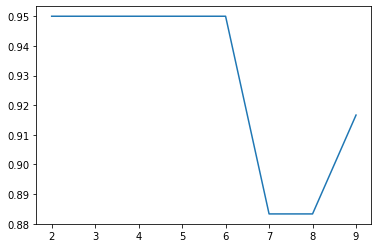

In [99]:
#DecisionTree Classifier
# Writing codes to get the right leave nodes with best accuracy
list1 = []
for leaves in range(2,10):
    classifier = DecisionTreeClassifier(max_leaf_nodes = leaves, random_state=0, criterion='entropy')
    classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_test)
    list1.append(accuracy_score(y_test,y_pred))
#print(mylist)
plt.plot(list(range(2,10)), list1)
plt.show()

### The plot above shows us leave_nodes 2-6 has the highest accuracy

In [101]:
# Tuning DecisionTreeClassifier with the right leave_nodes and fitting
dt_clf = DecisionTreeClassifier(max_leaf_nodes=2, random_state=0, criterion='entropy')
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.95

In [105]:
# Running predictions with model DecisionTreeClassifier
dt_pred = dt_clf.predict(X_test)
dt_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0])

In [108]:
# Let us check our confusion_matrix on the DecisionTreeClassifier tuned
confusion_matrix(y_test,dt_pred)

array([[43,  0],
       [ 3, 14]])

In [109]:
# Let us run a DecisionTreeClassifier report on the best model tuned
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        43
           1       1.00      0.82      0.90        17

    accuracy                           0.95        60
   macro avg       0.97      0.91      0.93        60
weighted avg       0.95      0.95      0.95        60



# SO FAR SO GOOD, WE HAVE COME UP WITH THE BEST MODEL SO FAR. 
# DecisionTreeClassifier with a leave_node tuned to 2 for best accuracy IS THE BEST SCORE WE HAVE = 95% ACCURACY